# 합성곱 신경망을 사용한 이미지 분류

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/8-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

#수업시간에 배운 CNN을 이용하여 이미지를 분류해 보자!!!


데이터 셋 정보: https://www.cs.toronto.edu/~kriz/cifar.html

## CIFAR-10 데이터 셋 읽어오기

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt


(train_input, train_target), (test_input, test_target) = \
    cifar10.load_data()


Using TensorFlow backend.


##로드한 데이터의 shape을 확인하시오 (샘플 수: 50000, 32 x 32, RGB format).
##데이터 셋의 클래스 수를 확인하시오 (numpy unique() 활용)

In [2]:
print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

import numpy as np

print(np.unique(train_target, return_counts=True))

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


## 이미지의 픽셀값을 0~1값으로 정규화하시오

In [3]:
#이미지 정규화 (전체 픽셀을 각각 255로 나눔, Numpy Braodcast 특성 활용)
train_scaled = train_input.reshape(-1,32,32,3) / 255.0

##데이터 세트를 훈련데이터 (80%)와 검증세트로 분리하시오

In [4]:
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

#분류가 잘 되었는지 확인하시오 (훈련 세트 = 40000, 검증세트 = 10000)

In [5]:
#shape를 출력
print(train_scaled.shape, train_target.shape)
print(val_scaled.shape, val_target.shape)

(40000, 32, 32, 3) (40000, 1)
(10000, 32, 32, 3) (10000, 1)


## matplotlib의 imshow() 메소드를 사용하여 정규화된 훈련세트의 0번째 인덱스의 이미지를 color bar와 함께 출력하시오. 

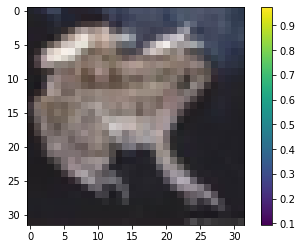

In [6]:
import matplotlib.pyplot as plt
plt.imshow(train_scaled[0].reshape(32,32,3), cmap="viridis")
plt.colorbar()
plt.show()

## 합성곱 신경망 만들기

In [7]:
model = keras.Sequential()

##첫번째 합성곱 층을 생성후 모델에 추가하시오.

In [8]:
model.add(keras.layers.Conv2D(32,kernel_size=3, activation='relu', padding='same', input_shape=(32,32,3)))

2022-08-19 09:06:41.651872: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 09:06:41.652909: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


## 2x2 최대 풀링 (max pooling) 층을 추가하시오
stride: 2

In [9]:
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

##두번째 합성곱 층을 생성 후 모델에 추가하시오

In [10]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))

## 2x2 최대 풀링 (max pooling) 층을 추가하시오.
stride: 2

In [11]:
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

## 최종 출력을 위해 Flatten 층, Dense 층, Dropout 층 등을 추가하시오

In [12]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation='softmax'))

##model.summary()를 사용하여 모델이 잘 구성되었는지 확인

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               409700    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

##utils.plot_model()을 사용하여 모델이 잘 구성되었는지 확인

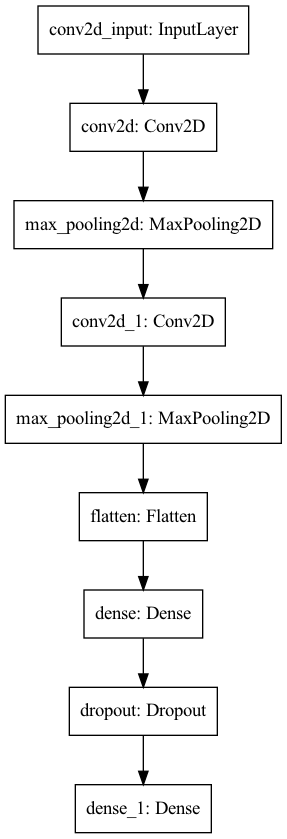

In [14]:
keras.utils.plot_model(model, to_file='cifar_model.png')

## 모델 컴파일과 학습

In [15]:
#accuracy는 매개변수를 통해 별도 추가
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## ModelCheckPoint 콜백 및 Early_stopping 콜백 사용을 사용하여 최적의 모델을 찾고 저장하시오.

In [16]:
##modelCheckPoint 콜백과 Early_stopping 콜백은 리스트로 동시에 전달 가능
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cifar-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=30, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 162s 4ms/sample - loss: 1.5374 - accuracy: 0.4438 - val_loss: 1.2067 - val_accuracy: 0.5762
Epoch 2/30
40000/40000 [==============================] - 164s 4ms/sample - loss: 1.1820 - accuracy: 0.5821 - val_loss: 1.0621 - val_accuracy: 0.6305
Epoch 3/30
40000/40000 [==============================] - 159s 4ms/sample - loss: 1.0531 - accuracy: 0.6281 - val_loss: 0.9490 - val_accuracy: 0.6702
Epoch 4/30
40000/40000 [==============================] - 162s 4ms/sample - loss: 0.9704 - accuracy: 0.6569 - val_loss: 0.9403 - val_accuracy: 0.6669
Epoch 5/30
40000/40000 [==============================] - 207s 5ms/sample - loss: 0.8929 - accuracy: 0.6833 - val_loss: 0.8970 - val_accuracy: 0.6830
Epoch 6/30
40000/40000 [==============================] - 159s 4ms/sample - loss: 0.8315 - accuracy: 0.7054 - val_loss: 0.8863 - val_accuracy: 0.6915
Epoch 7/30
40000/40000 [==========================

## matplotlib를 사용하여 학습 세트와 검증세트의 Loss율을 확인하시오.

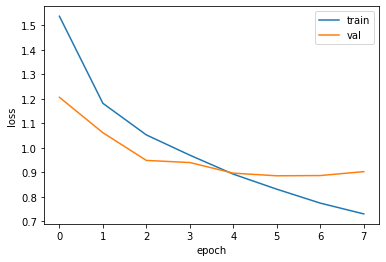

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## model.evaluate()를 사용하여 검증 세트에 대한 성능을 측정하시오

In [18]:
model.evaluate(val_scaled, val_target)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.8862841965675354, 0.6915]

##검증세트의 두번째 (인덱스 1) 이미지 출력

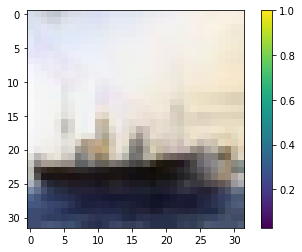

In [19]:
plt.imshow(val_scaled[1].reshape(32,32,3), cmap='viridis')
plt.colorbar()
plt.show()

## 검증세트 두번째 (인덱스 1) 샘플의 예측결과를 확인

In [20]:
preds = model.predict(val_scaled[1:2])
print(preds)

[[6.2574376e-04 1.4505254e-06 2.6321261e-06 5.2651814e-07 1.0809381e-07
  6.0373196e-08 4.9400302e-09 1.0639859e-08 9.9932706e-01 4.2365140e-05]]


## 위 예측결과를 그래프로 출력 후 확인

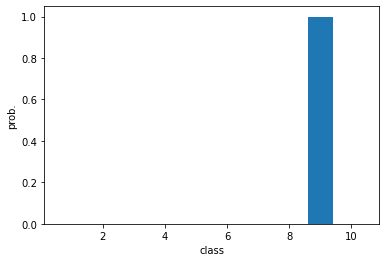

In [21]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

##예측결과를 보기좋게 출력

In [22]:
classes = ['비행기', '자동차', '새', '고양이', '사슴',
           '강아지', '개구리', '말', '배', '트럭']

In [23]:
import numpy as np
print(classes[np.argmax(preds)])

배


##테스트 세트에 대한 성능을 평가해보자 (evaluate() 사용)

In [24]:
#테스트 데이터도 정규화가 필요합니다.
#성능평가시 evaluate()를 사용합니다.
test_scaled = test_input.reshape(-1,32,32,3) / 255.0
model.evaluate(test_scaled, test_target)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.8872031529426575, 0.6907]

## 성능을 향상시켜보세요 (레이어 추가 등)

In [76]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

(train_i, train_t), (test_i, test_t) = cifar10.load_data()
    
train, val, train_t, val_t = train_test_split(train_i, train_t, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.4, rotation_range=40, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen.fit(train_i)
test_generator = test_datagen.flow(test_i, test_t)


In [77]:
model2 = keras.Sequential()

model2.add(keras.layers.Conv2D(32,kernel_size=3, activation='relu', padding='same', input_shape=(32,32,3)))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(100, activation='relu'))
model2.add(keras.layers.Dropout(0.3))
model2.add(keras.layers.Dense(10, activation='softmax'))

In [78]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 4, 4, 256)        

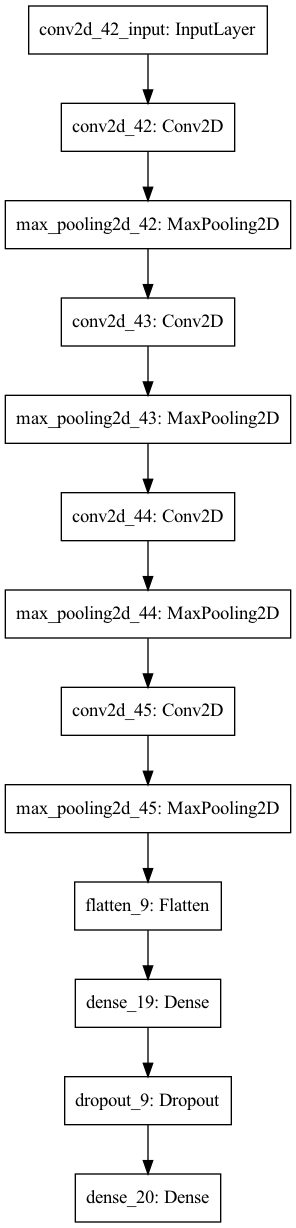

In [79]:
keras.utils.plot_model(model2, to_file='cirfar_model2.png')

In [80]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb2 = keras.callbacks.ModelCheckpoint('best-cifar-model2-2.h5', save_best_only=True)
early_stopping_cb2 = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history2 = model2.fit_generator(train_datagen.flow(train, train_t, batch_size=64),
                                steps_per_epoch=1000, epochs=30,
                                validation_data=train_datagen.flow(val, val_t, batch_size=64),
                                validation_steps=10, callbacks=[checkpoint_cb2, early_stopping_cb2])

Epoch 1/30
1000/1000 [==============================] - 471s 471ms/step - loss: 1.7375 - accuracy: 0.3659 - val_loss: 1.4851 - val_accuracy: 0.4656
Epoch 2/30
1000/1000 [==============================] - 466s 466ms/step - loss: 1.4201 - accuracy: 0.4950 - val_loss: 1.2995 - val_accuracy: 0.5484
Epoch 3/30
1000/1000 [==============================] - 467s 467ms/step - loss: 1.2690 - accuracy: 0.5509 - val_loss: 1.2865 - val_accuracy: 0.5109
Epoch 4/30
1000/1000 [==============================] - 469s 469ms/step - loss: 1.1807 - accuracy: 0.5834 - val_loss: 1.1691 - val_accuracy: 0.5891
Epoch 5/30
1000/1000 [==============================] - 470s 470ms/step - loss: 1.1091 - accuracy: 0.6110 - val_loss: 1.1315 - val_accuracy: 0.5875
Epoch 6/30
1000/1000 [==============================] - 473s 473ms/step - loss: 1.0596 - accuracy: 0.6312 - val_loss: 1.1056 - val_accuracy: 0.5906
Epoch 7/30
1000/1000 [==============================] - 474s 474ms/step - loss: 1.0220 - accuracy: 0.6433 - val_

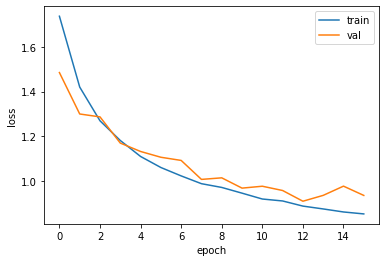

In [81]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [82]:
model2.evaluate(val_scaled, val_target)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.7583646266937256, 0.739]

In [83]:
model2.evaluate(test_scaled, test_target)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.7757173308372498, 0.7312]